### [Algorithmic Trading with MACD in Python](https://medium.com/codex/algorithmic-trading-with-macd-in-python-1c2769a6ad1b)

In [1]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mpl_dates

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [2]:
def get_stock_price(symbol,start_date):
  df = yf.download(symbol, start=start_date, threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  df.columns = ['open','high','low','close','volume']
  return df

symbol = 'GOOGL'
df = get_stock_price(symbol, '2020-01-01')
googl = df

[*********************100%***********************]  1 of 1 completed


In [3]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(googl['close'], 26, 12, 9)
googl_macd.tail()

,macd,signal,hist
Date,,,
2022-08-29,-0.311594,0.870501,-1.182095
2022-08-30,-0.772806,0.541839,-1.314646
2022-08-31,-1.099024,0.213667,-1.312690
2022-09-01,-1.403507,-0.109768,-1.293739
2022-09-02,-1.634044,-0.414623,-1.219421


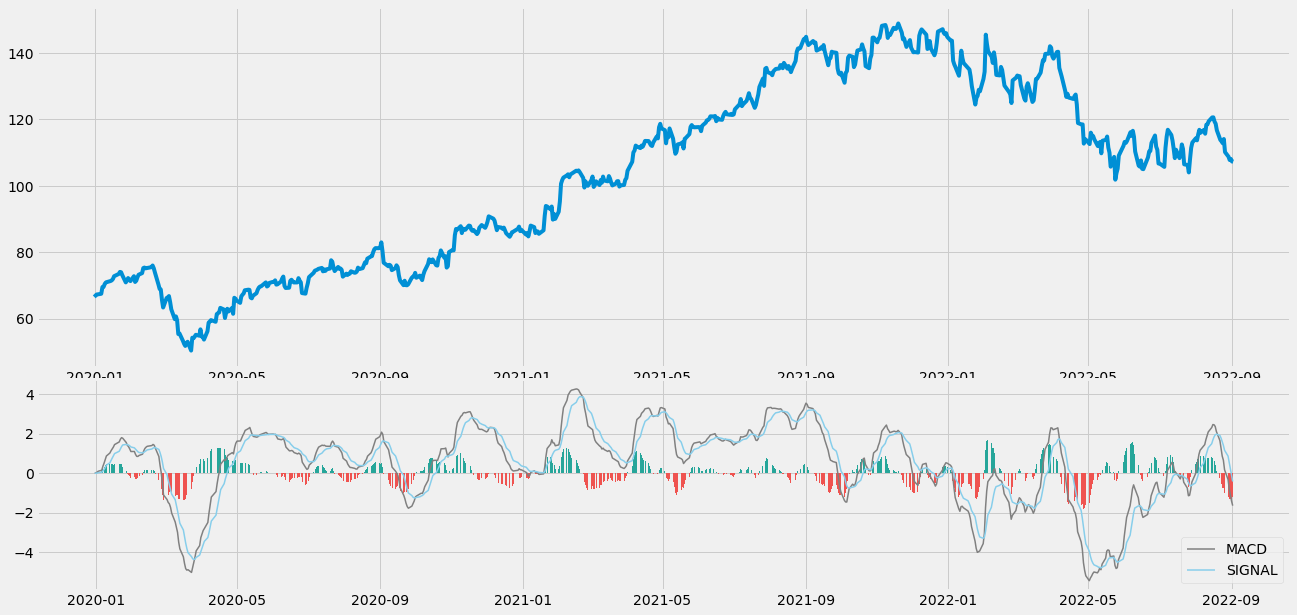

In [4]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(googl['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])


In [5]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(googl['close'], googl_macd)

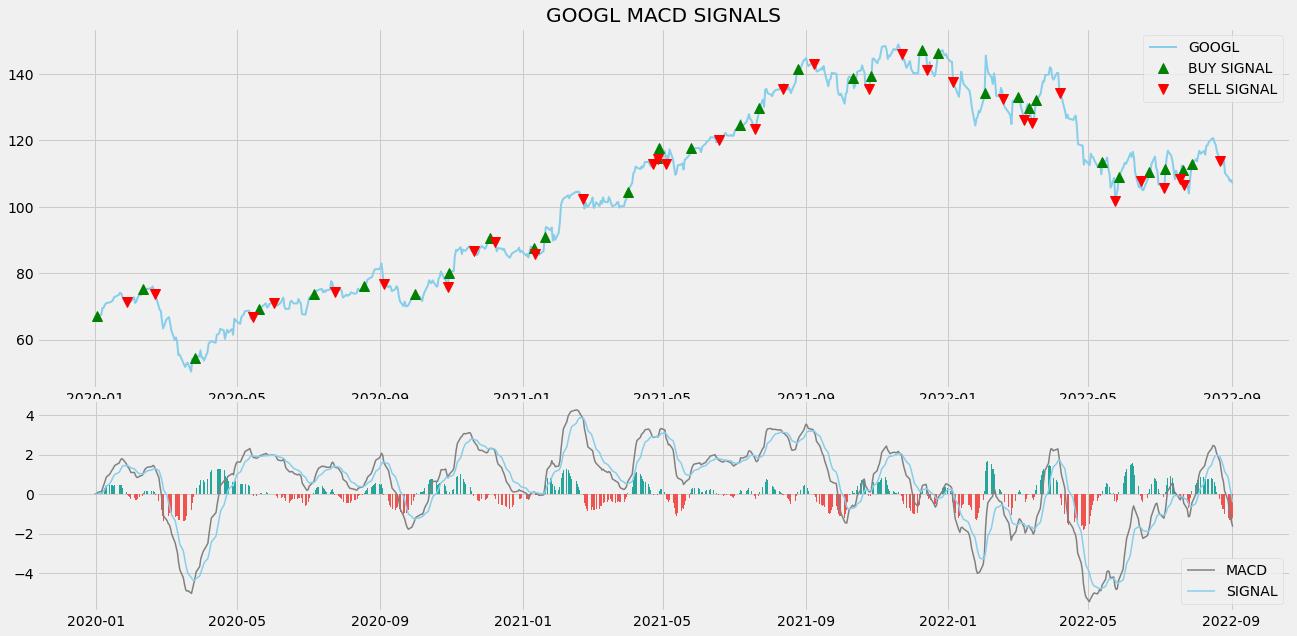

In [6]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(googl['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(googl.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(googl.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(googl_macd)):
    if str(googl_macd['hist'][i])[0] == '-':
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#ef5350')
    else:
        ax2.bar(googl_macd.index[i], googl_macd['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [7]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(googl['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = googl_macd['macd']
signal = googl_macd['signal']
close_price = googl['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(googl.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(googl.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
Date,,,,,
2019-12-31,66.606499,0.000000,0.000000,0,1
2020-01-02,67.324501,0.057277,0.011455,1,1
2020-01-03,67.365997,0.104809,0.030126,0,1
2020-01-06,67.550003,0.155533,0.055207,0,1
2020-01-07,69.578003,0.355280,0.115222,0,1
...,...,...,...,...,...
2022-08-29,108.800003,-0.311594,0.870501,0,0
2022-08-30,107.800003,-0.772806,0.541839,0,0
2022-08-31,108.129997,-1.099024,0.213667,0,0


In [8]:
googl_ret = pd.DataFrame(np.diff(googl['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/googl['close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in GOOGL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the MACD strategy by investing $100k in GOOGL : 879.57
Profit percentage of the MACD strategy : 0%


In [11]:
def get_benchmark(start_date, investment_value):
    spy = get_stock_price('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))


[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : 21896.16
Benchmark Profit percentage : 21%
MACD Strategy profit is -21% higher than the Benchmark Profit
